# Gradient-free reinforcement learning predictors in thoth-adviser

| Info | Data |
| ------:| -----------:|
| **Author** | Fridolin Pokorny <fridolin@redhat.com> |
| **Date** | 27th Oct 2020 |
| **Last change** | 27th Oct 2020 |

This Jupyter Notebook demonstrates how to use Thoth's adviser from Jupyter notebooks as well as shows gradient-free reinforcement learning predictors implemented.

**NOTE** the resolution is considerably slower as components used during the resolution keep history. To accomplish faster resolution process, but without plots and history information, set ``keep_history=False`` in predictor's constructor.

## Importing required bits and library versions

In [1]:
import yaml
import random
from pprint import pprint

from thoth.adviser import Resolver
from thoth.adviser import PipelineBuilder
from thoth.adviser import PipelineConfig
from thoth.adviser import RecommendationType
from thoth.adviser import __version__
from thoth.python import Project
from thoth.common import RuntimeEnvironment
from thoth.common import init_logging
from thoth.storages import GraphDatabase
import thoth.adviser.predictors as predictors

init_logging()
print("Adviser version: ", __version__)

2020-10-27 16:37:19,107 1268734 WARNING  thoth.common:344: Logging to a Sentry instance is turned off
2020-10-27 16:37:19,112 1268734 INFO     thoth.common:366: Logging to rsyslog endpoint is turned off


Adviser version:  0.18.0


## Project instantiation

We run a ``flask`` application on Red Hat Enterprise Linux 8 (linux, x86_64) considering pre-aggregated knowledge stored and exposed locally. See [thoth-station/storages](https://github.com/thoth-station/storages) for more info on how to setup a local database instance.

In [2]:
PIPFILE = """
[[source]]
name = "pypi"
url = "https://pypi.org/simple"
verify_ssl = true

[dev-packages]

[packages]
flask = "*"

[requires]
python_version = "3.6"
"""

runtime_environment = RuntimeEnvironment.from_dict({
    "hardware": {
        "cpu_family": None,
        "cpu_model": None
    },
    "operating_system": {
        "name": "rhel",
        "version": "8"
    },
    "python_version": "3.6",
    "cuda_version": None,
    "platform": "linux-x86_64"
})
project = Project.from_strings(PIPFILE, runtime_environment=runtime_environment)

## Pipeline configuration

Next, we build a software stack resolution pipeline. This pipeline is extended with a prepared scoring that randomly assigns scores to packages that occur in the dependency graph during the resolution process. This scoring is done solely on package-version level and does not include any causal scores of packages (package X has a score of S if seen together with Y and Z). The dataset was aggregated using a resolver that resolved all the flask stacks considering the aggregated knowledge from [thoth-solver](https://github.com/thoth-station/solver) and exposed resolved packages were randomly scored (see all the `steps`). Some of [the boot pipeline units](https://thoth-station.ninja/docs/developers/adviser/boots.html) check for the configuration used and [the sieve pipeline unit](https://thoth-station.ninja/docs/developers/adviser/sieves.html) used makes sure only packages that are installable into the environment are occuring in the resolved software stacks. This makes sure all the software stacks resolved are installable into the environment and the application builds successfully. No runtime characteristics of the software stacks resolved are considered directly, the runtime characteristics are mocked using the scoring mechanism done in [scoring steps](https://thoth-station.ninja/docs/developers/adviser/steps.html). See [Markov decision process in resolver](https://thoth-station.ninja/docs/developers/adviser/introduction.html#introduction-rl) and [reinforcement learning based dependency resolution](https://thoth-station.ninja/docs/developers/adviser/predictors/reinforcement_learning.html) for more in-depth information.

In [3]:
_PIPELINE_CONF = """
boots:
- configuration:
    package_name: null
  name: PythonVersionBoot
  unit_run: false
- configuration:
    package_name: null
  name: RHELVersionBoot
  unit_run: false
- configuration:
    default_platform: linux-x86_64
  name: PlatformBoot
  unit_run: false
- configuration:
    package_name: null
  name: FullySpecifiedEnvironment
  unit_run: false
pseudonyms: []
sieves:
- configuration:
    package_name: null
    without_error: true
  name: SolvedSieve
  unit_run: false
steps:
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.1.2
    score: 0.4831009995196658
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.5.2
    score: 0.2699565763941205
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.1'
    score: 0.33981425857639347
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.1.1
    score: -0.6515075971876456
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.6'
    score: -0.4030016776194121
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.11.1
    score: -0.2234501579890833
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.12.5
    score: 0.4511785146682805
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.12.4
    score: 0.048139537620904616
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.2'
    score: 0.4335021181614165
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.12'
    score: 0.46501366207972605
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.11'
    score: -0.3644536448363518
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.0.3
    score: 0.4355354744572779
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.0.2
    score: 0.4143318234859481
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.12.3
    score: -0.7271945949689507
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.5.1
    score: 0.8970965642672828
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.10'
    score: -0.7744827193941914
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.0.4
    score: -0.15481599023828885
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.0.1
    score: -0.47008920236846174
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.4'
    score: -0.6431209313519444
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.6.1
    score: 0.6198247559449923
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.12.2
    score: 0.7927134855861386
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.3.1
    score: -0.8660819672216105
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.12.1
    score: 0.7171395861721324
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '1.0'
    score: 0.31253404493978576
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.5'
    score: 0.2768501523507281
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 0.10.1
    score: -0.5456351321876862
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: 1.1.0
    score: 0.15656003271774144
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: flask
    package_version: '0.3'
    score: -0.20267495429913174
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: itsdangerous
    package_version: 1.1.0
    score: -0.7209241429497122
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: itsdangerous
    package_version: '0.24'
    score: 0.587470798212004
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: itsdangerous
    package_version: '0.21'
    score: 0.27662717975522644
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: itsdangerous
    package_version: '0.22'
    score: -0.2576069292326648
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: itsdangerous
    package_version: '0.23'
    score: -0.5558144338403734
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.0'
    score: 0.48133548933535164
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '7.1'
    score: -0.8495122798524659
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.6'
    score: -0.6428643676550727
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: 7.1.1
    score: -0.7831949055705778
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.3'
    score: 0.4570901213054086
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.1'
    score: 0.21241770661228654
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.5'
    score: 0.7990094658223992
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.7'
    score: -0.9112269325735378
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.2'
    score: -0.13740520075002616
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '5.1'
    score: -0.37216870988328066
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '6.4'
    score: 0.014245008070538301
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '7.0'
    score: -0.19519922588455074
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.5'
    score: 0.4161379187517422
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '5.0'
    score: -0.028277539452225442
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.3'
    score: 0.31884450175874646
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.4'
    score: 0.1337237859441851
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '3.2'
    score: -0.6627209781880397
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '3.3'
    score: 0.7557716590159231
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.2'
    score: -0.28251679577280653
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.0'
    score: 0.10334365232039433
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '3.1'
    score: 0.21325533214172254
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.1'
    score: 0.6528873464465388
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '4.0'
    score: 0.2632529889225099
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '2.6'
    score: -0.5744786276474063
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '3.0'
    score: -0.4787673571188851
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: click
    package_version: '4.1'
    score: 0.1792015095535937
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.10.1
    score: -0.15615636062945915
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.11.1
    score: 0.3225266371354203
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.5
    score: -0.07547957629776847
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.10.3
    score: -0.9956892432971471
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.11.0
    score: -0.8997153254720929
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.2
    score: -0.46877097493729236
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.10.2
    score: -0.1591073324541834
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.4
    score: 0.4873108843191698
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.4'
    score: 0.3445631686064785
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.7.2
    score: 0.9566754564410913
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.5'
    score: 0.8805837835591084
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.7.1
    score: -0.09271248622221484
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.5.3
    score: 0.014825093936008171
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.8'
    score: -0.49600843006769346
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.5.1
    score: 0.4099765194803935
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.10'
    score: 0.537908095840081
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.6
    score: 0.18735899368212894
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.8.1
    score: 0.835792371841293
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.5.2
    score: -0.283005736659246
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.7.3
    score: 0.6299285790729927
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.4.1
    score: 0.15710877140835322
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.9'
    score: 0.5737837953251399
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.5.5
    score: -0.5309343025081597
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.1
    score: -0.6880088630476822
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.6'
    score: 0.4186742719050571
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.9.3
    score: 0.10783178221109835
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: 2.5.4
    score: -0.8301165266277044
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: jinja2
    package_version: '2.7'
    score: -0.7503472553858952
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 1.0.0
    score: -0.5627240503927933
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.4
    score: -0.7955794469603026
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.1
    score: -0.6154228194866802
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.15
    score: 0.6436051880136167
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.3
    score: -0.46451824804859454
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.2
    score: 0.7527352529453377
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.12'
    score: 0.3108773305897601
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.7.2
    score: -0.0822962948252024
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.14.1
    score: -0.5067449846120331
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.8.2
    score: -0.14313234541084063
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.2
    score: -0.5613584816854333
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.3
    score: -0.012968330220737956
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.0
    score: -0.6943173613034779
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.10'
    score: 0.19281806146394764
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.10.4
    score: 0.1917768567222562
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.8'
    score: -0.49717176003637364
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.14'
    score: 0.36342073805314956
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.1
    score: -0.7768956528082471
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.14
    score: -0.09255258734158711
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.6.2
    score: 0.5239243981041293
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.4
    score: 0.6833386963449342
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.12.1
    score: -0.2521722948177041
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.5
    score: 0.9069994953070055
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.10.1
    score: -0.3516878859906538
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.12.2
    score: -0.8841496670116249
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.5
    score: 0.4638151896892555
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.7'
    score: 0.06541233905903132
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.10
    score: 0.055347574836507984
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.12
    score: 0.8578269860043537
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.7
    score: -0.20201540000514173
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.4
    score: 0.7992281692858909
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.2
    score: -0.5041887726679841
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.10.2
    score: -0.9579314799858822
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.8
    score: -0.9856183220298129
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.6
    score: -0.865199343779385
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.1
    score: -0.8582853002226931
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.13
    score: 0.33795555659256116
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.5
    score: -0.73537630254995
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.13'
    score: 0.5692388485815068
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.11
    score: -0.8113484070162356
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.9.6
    score: -0.15284275396015845
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.16.0
    score: 0.34672909458660306
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.6
    score: -0.19475743579546245
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.11.9
    score: -0.5026873321594287
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.8.1
    score: -0.1027729043337362
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.11'
    score: -0.44290971066611906
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.15.3
    score: -0.11373850989308609
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: '0.9'
    score: 0.3042897879970441
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.8.3
    score: 0.8527339660162552
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.7.1
    score: -0.18717188409505603
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.6.1
    score: 0.729300788060431
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 0.16.1
    score: 0.31770148999684356
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: werkzeug
    package_version: 1.0.1
    score: -0.8987894163994194
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: 1.1.0
    score: 0.4320392258448069
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: 1.1.1
    score: -0.10158190743229278
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '1.0'
    score: 0.5176147342595345
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.23'
    score: -0.31949896696401625
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.16'
    score: -0.28307331539927305
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.21'
    score: -0.5116051356320632
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.14'
    score: 0.3636007427054564
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.12'
    score: 0.36626915992542775
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.11'
    score: -0.7137645597429807
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: 0.9.2
    score: -0.49204532117291544
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.18'
    score: 0.3552217713981589
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.22'
    score: -0.11654043279237114
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.15'
    score: -0.4016915017524556
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: 0.9.3
    score: -0.4998035511845975
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.20'
    score: 0.9987471310003584
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.13'
    score: -0.4082552195684308
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.19'
    score: 0.9558889691537253
  name: SetScoreStep
  unit_run: false
- configuration:
    index_url: https://pypi.org/simple
    multi_package_resolution: false
    package_name: markupsafe
    package_version: '0.17'
    score: -0.9838040684770195
  name: SetScoreStep
  unit_run: false
strides: []
wraps: []
"""
                           

def get_pipeline_config() -> PipelineConfig:
    """Get pipeline configuration."""
    conf = yaml.safe_load(_PIPELINE_CONF)
    return PipelineBuilder.from_dict(conf)

pipeline_config = get_pipeline_config()

![State space](https://thoth-station.ninja/docs/developers/adviser/images/state_space_interpolated.png)

## Checking the state space

As a very first step we resolve all the software stacks that can be resolved given the pre-aggregated knowledge about dependencies (captured using [thoth-solver](https://github.com/thoth-station/solver)). This is [accomplished using random walks in the dependency graph](https://thoth-station.ninja/docs/developers/adviser/predictors/random_walk.html) that produce resolved software stacks (considering the software stack resolution pipeline used).

In [4]:
predictor = predictors.RandomWalk()
pipeline_config = get_pipeline_config()
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=90000000,   # Set to a very high number to resolve all the stacks.
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)

2020-10-27 13:28:09,640 1266326 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 13:28:09,641 1266326 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 13:28:09,681 1266326 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


In [5]:
%%time

random.seed(30)
resolver.graph.cache_clear()
resolver.log_iteration = 750000  # limit log verbosity
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
TOP_SCORE = report.to_dict()["products"][0]["score"]
print(f"Top rated software stack has a score of {TOP_SCORE}")

2020-10-27 11:59:43,527 1257435 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 11:59:43,528 1257435 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 11:59:43,529 1257435 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 11:59:43,724 1257435 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 11:59:43,790 1257435 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 11:59:43,794 1257435 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 11:59:43,799 125743

Top rated software stack has a score of 5.041615832368997
CPU times: user 27min 51s, sys: 462 ms, total: 27min 52s
Wall time: 28min 2s


**Note** we do not keep history during the resolution so the overall time should not be directly compared with other resolutions done in this notebook, except for the TD-learning one shown below that does not keep the history.

The dataset can generate 7,861,340 software stacks, the top rated software stack that can be found during the resolution process has a score of 5.041615832368997. Now, let's assign some restrictions to the resolution process to see how different reinforcement learning based predictors behave. We select just a small portion of the state space of all the possible software stacks not to resolve all the software stacks. When reinforcement learning algorithms are used, they require certain overhead (in comparision to random walks in the dependency graph) so resolving all the software stacks would be expensive and undesired as reinforcement learning based dependency resolution should narrow down the dependency resolution to resolve high quality software stacks faster (without a need to check all the possibilities).

In [6]:
STACKS_LIMIT = 70000
ALL_STACKS_COUNT = 7861340

In [7]:
print(f"The resolution process using reinforcement learning algorithms will resolve {100*STACKS_LIMIT/ALL_STACKS_COUNT:0.4}% of all the stacks possible")

The resolution process using reinforcement learning algorithms will resolve 0.8904% of all the stacks possible


The resolution works on `flask` (in any version) software stack that can  have 6 dependencies.

In [8]:
pipeline_config = get_pipeline_config()

packages = {}
for step in pipeline_config.steps:
    version_set = packages.get(step.configuration["package_name"])
    if version_set is None:
        version_set = set()
        packages[step.configuration["package_name"]] = version_set

    version_set.add(step.configuration["package_version"])
    
pprint(f"The dataset consists of {len(packages)} packages (considering {len(packages) + 1} dimensions)")
pprint(packages)

for package_name, package_versions in packages.items():
    print(f"Package {package_name!r} has {len(package_versions)} versions")

'The dataset consists of 6 packages (considering 7 dimensions)'
{'click': {'2.0',
           '2.1',
           '2.2',
           '2.3',
           '2.4',
           '2.5',
           '2.6',
           '3.0',
           '3.1',
           '3.2',
           '3.3',
           '4.0',
           '4.1',
           '5.0',
           '5.1',
           '6.0',
           '6.1',
           '6.2',
           '6.3',
           '6.4',
           '6.5',
           '6.6',
           '6.7',
           '7.0',
           '7.1',
           '7.1.1'},
 'flask': {'0.1',
           '0.10',
           '0.10.1',
           '0.11',
           '0.11.1',
           '0.12',
           '0.12.1',
           '0.12.2',
           '0.12.3',
           '0.12.4',
           '0.12.5',
           '0.2',
           '0.3',
           '0.3.1',
           '0.4',
           '0.5',
           '0.5.1',
           '0.5.2',
           '0.6',
           '0.6.1',
           '1.0',
           '1.0.1',
           '1.0.2',
           '1.0

Each dependency can occur in different versions, considering version range specifications and dependency requirements in the dependency graph. By simply creating all the combinations of packages we would end up with `28*5*26*28*53*18=97,231,680` software stacks, but this did not happen. Some of the combinations are not valid respecting the dependency graph and some of them do not produce installable software stack in the desired environment:

In [9]:
print(f"Only {(ALL_STACKS_COUNT*100)/97231680:0.4f}% combinations are valid and installable software stack resolutions for the specified environment.")

Only 8.0852% combinations are valid and installable software stack resolutions for the specified environment.


## Temporal Difference learning (step==1)

The very first approach will be using [TD-learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) as a predictor. See [the documentation for more info](https://thoth-station.ninja/docs/developers/adviser/predictors/temporal_difference_learning.html).

In [10]:
predictor = predictors.TemporalDifference(keep_history=True, trace=False, step=1)
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=STACKS_LIMIT,
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)

2020-10-27 13:55:03,074 1268734 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 13:55:03,075 1268734 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 13:55:03,113 1268734 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


2020-10-27 13:55:03,639 1268734 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 13:55:03,639 1268734 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 13:55:03,640 1268734 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 13:55:03,820 1268734 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 13:55:03,879 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 13:55:03,882 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 13:55:03,886 126873

CPU times: user 16min 9s, sys: 631 ms, total: 16min 10s
Wall time: 16min 25s


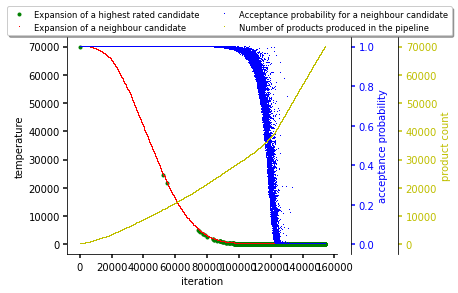

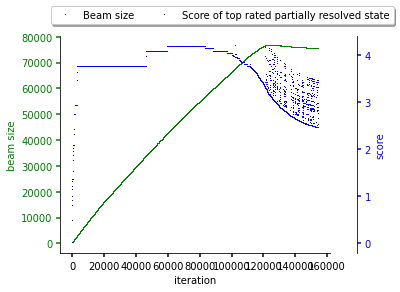

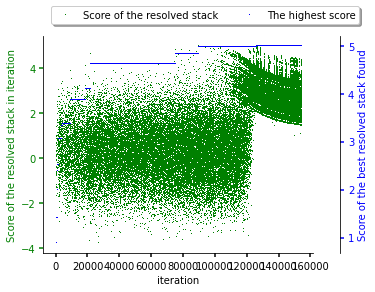

In [11]:
%%time

random.seed(30)  # Make starting point same for different predictors.
resolver.graph.cache_clear()
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
td_score = report.to_dict()["products"][0]["score"]
td_plots = {
    "predictor": predictor.plot(),
    "beam": resolver.beam.plot(),
    "resolver": resolver.plot(),
}

In [12]:
print(f"The resolution process found a score of {td_score} for the best candidate")

The resolution process found a score of 4.998378025562521 for the best candidate


Considering smaller portion of software stacks (state space explored) and thus reducing time needed for the resolution, we obtained a result which is very close to the best software stack that can be found in the dataset. As the method is stochastic, different results can be obtained with different seed provided.

Now let's consider the same resolution process but without the history being kept. Notice the performance difference.

In [13]:
predictor = predictors.TemporalDifference(keep_history=False, trace=False, step=1)
pipeline_config = get_pipeline_config()
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=STACKS_LIMIT,
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)


2020-10-27 14:11:30,951 1268734 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 14:11:30,952 1268734 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 14:11:31,019 1268734 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


In [14]:
%%time

random.seed(30)  # Make starting point same for different predictors.
resolver.graph.cache_clear()
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
print("Found a software stack with score: ", report.to_dict()["products"][0]["score"])

2020-10-27 14:11:31,368 1268734 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 14:11:31,369 1268734 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 14:11:31,370 1268734 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 14:11:31,386 1268734 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 14:11:31,516 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:11:31,521 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:11:31,528 126873

Found a software stack with score:  5.041615832368997
CPU times: user 6min 52s, sys: 512 ms, total: 6min 53s
Wall time: 7min 2s


## n-step Temporal Difference learning (step==2)

The next predictor will tweak step in the temporal difference learning with `step==2`.

In [15]:
predictor = predictors.TemporalDifference(keep_history=True, step=2, trace=True)
pipeline_config = get_pipeline_config()
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=STACKS_LIMIT,
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)

2020-10-27 14:18:34,285 1268734 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 14:18:34,286 1268734 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 14:18:34,352 1268734 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


2020-10-27 14:18:34,632 1268734 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 14:18:34,633 1268734 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 14:18:34,634 1268734 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 14:18:34,647 1268734 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 14:18:34,790 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:18:34,797 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:18:34,804 126873

CPU times: user 22min 58s, sys: 671 ms, total: 22min 59s
Wall time: 23min 15s


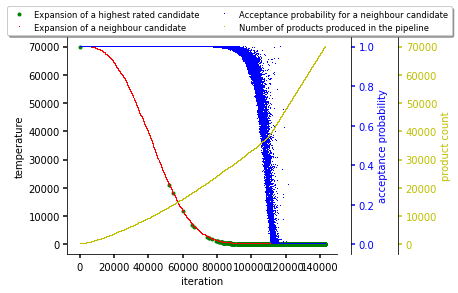

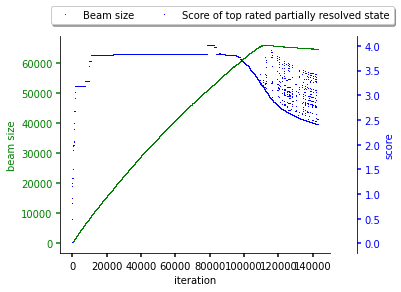

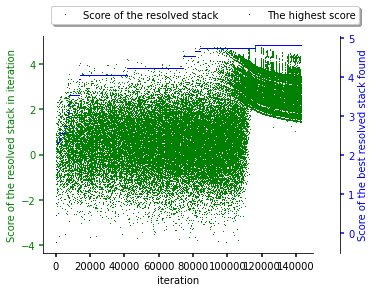

In [16]:
%%time

random.seed(30)  # Make starting point same for different predictors.
resolver.graph.cache_clear()
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
td_2_steps_score = report.to_dict()["products"][0]["score"]
td_2_steps_plots = {
    "predictor": predictor.plot(),
    "beam": resolver.beam.plot(),
    "resolver": resolver.plot(),
}

In [17]:
print(f"The resolution process found a score of {td_2_steps_score} for the best candidate")

The resolution process found a score of 4.801921041548717 for the best candidate


## n-step Temporal Difference learning (step==3)

Let's keep increasing the step size in TD-learning:

In [18]:
predictor = predictors.TemporalDifference(keep_history=True, step=3, trace=True)
pipeline_config = get_pipeline_config()
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=STACKS_LIMIT,
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)

2020-10-27 14:41:52,002 1268734 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 14:41:52,003 1268734 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 14:41:52,068 1268734 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


2020-10-27 14:41:52,379 1268734 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 14:41:52,380 1268734 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 14:41:52,381 1268734 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 14:41:52,398 1268734 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 14:41:52,521 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:41:52,527 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 14:41:52,533 126873

CPU times: user 24min 47s, sys: 876 ms, total: 24min 48s
Wall time: 25min 9s


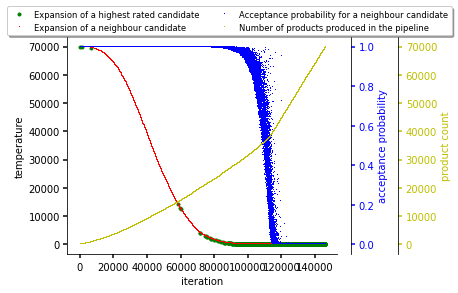

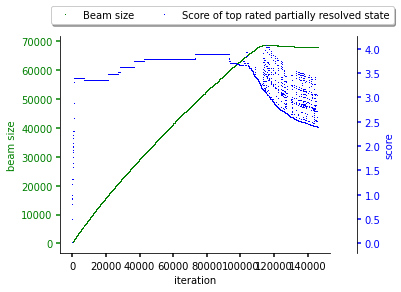

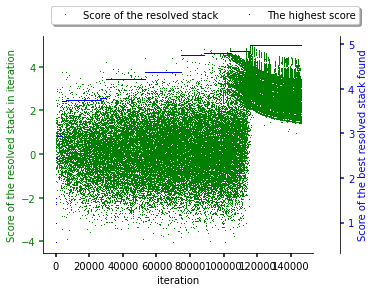

In [19]:
%%time

random.seed(30)  # Make starting point same for different predictors.
resolver.graph.cache_clear()
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
td_3_steps_score = report.to_dict()["products"][0]["score"]
td_3_steps_plots = {
    "predictor": predictor.plot(),
    "beam": resolver.beam.plot(),
    "resolver": resolver.plot(),
}

In [20]:
print(f"The resolution process found a score of {td_3_steps_score} for the best candidate")

The resolution process found a score of 4.96604193295499 for the best candidate


## Monte Carlo Tree Search

The next predictor used is MCTS (Monte Carlo Tree search):

In [21]:
predictor = predictors.MCTS(keep_history=True)
pipeline_config = get_pipeline_config()
resolver = Resolver.get_adviser_instance(
    predictor=predictor,
    project=project,
    recommendation_type=RecommendationType.STABLE,
    limit=STACKS_LIMIT,
    count=1,
    beam_width=None,
    pipeline_config=pipeline_config,
)

2020-10-27 15:07:03,852 1268734 INFO     alembic.runtime.migration:155: Context impl PostgresqlImpl.
2020-10-27 15:07:03,852 1268734 INFO     alembic.runtime.migration:162: Will assume transactional DDL.
2020-10-27 15:07:03,912 1268734 WARNING  thoth.storages.graph.postgres:361: The database schema is not in sync with library revisions, the current library revision heads: {'6389973bd8b6'}, database heads: {'7c261487d4d4'}


2020-10-27 15:09:51,238 1268734 INFO     thoth.adviser.resolver:1071: Scoring user's stack - see https://thoth-station.ninja/j/user_stack
2020-10-27 15:09:51,239 1268734 INFO     thoth.adviser.resolver:1083: Preparing initial states for the resolution pipeline
2020-10-27 15:09:51,240 1268734 INFO     thoth.adviser.resolver:618: Resolving direct dependencies
2020-10-27 15:09:51,250 1268734 INFO     thoth.adviser.resolver:653: Found direct dependency 'flask' with version specification '*'
2020-10-27 15:09:51,356 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.9', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 15:09:51,365 1268734 WARNING  thoth.adviser.sieves.solved:94: Removing package ('flask', '0.8.1', 'https://pypi.org/simple') due to build time error in the software environment - see https://thoth-station.ninja/j/buildtime_error
2020-10-27 15:09:51,375 126873

CPU times: user 1min 16s, sys: 344 ms, total: 1min 17s
Wall time: 1min 23s


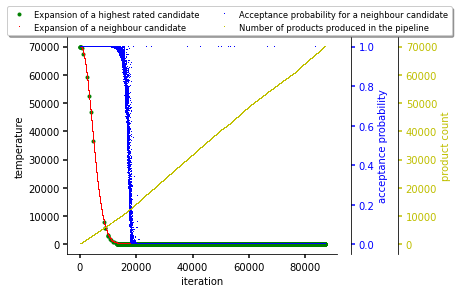

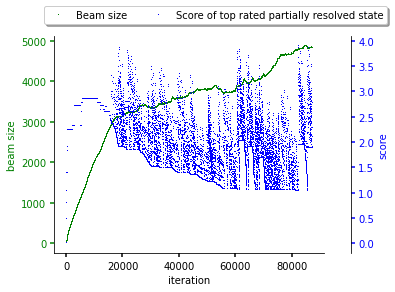

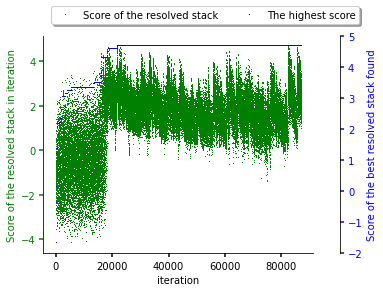

In [22]:
%%time

random.seed(33)
resolver.graph.cache_clear()
report = resolver.resolve(with_devel=False, user_stack_scoring=False)
mcts_score = report.to_dict()["products"][0]["score"]
mcts_plots = {
    "predictor": predictor.plot(),
    "beam": resolver.beam.plot(),
    "resolver": resolver.plot(),
}

In [23]:
print(f"The resolution process found a score of {mcts_score} for the best candidate")

The resolution process found a score of 4.700080861451139 for the best candidate


## Conclusion

As can be seen from the experiments conducted, it is possible to use reinforcement learning based dependency resolution to resolve high quality software stacks faster. The database of knowledge does not keep causal observations (package X has a score of S if seen with package Y and Z together) so TD-learning with `step=1` and `trace=False` looks like a good solution to go forward without possible bias introduced.

One of the disadvantages spotted during the experiment is the temperature function in MCTS-based predictor that drops quickly as this predictor produces software stacks faster than TD-learning. This can be considered for future improvements. As MCTS is not used in the deployment because of its bias and given the nature of observations we have about packages, we keep the implementation as-is for now.